# 1. Convex optimization for estimating covariance

In [3]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

# Below is an adaptation to Aditi's code
def estimate_theta(y, sparsity_pattern, n):
    """
    Estimate the covariance matrix Theta directly using sparse Cholesky decomposition and likelihood.

    Parameters:
        y (numpy.ndarray): Observed data vector.
        sparsity_pattern (list of lists): List of indices defining sparsity pattern for each row/column.
        n (int): Size of the covariance matrix.
        

    Returns:
        numpy.ndarray: Estimated covariance matrix Theta.
    """
    Theta = cp.Variable((n, n), PSD=True)  # PSD enforces positive definiteness

    # Enforce sparsity pattern
    constraints = []
    for i in range(n):
        for j in range(n):
            if j not in sparsity_pattern[i]:
                constraints.append(Theta[i, j] == 0)

    # Negative log-likelihood objective
    quadratic_term = 0.5 * cp.quad_form(y, Theta)  # y^T * Theta^-1 * y (quadratic term), return scaler

    # Log-determinant term
    log_det_term = cp.log_det(Theta)  # log(det(Theta))

    normalization_term = 0.5 * n * np.log(2 * np.pi)

    # Combine the terms into the objective
    objective = cp.Minimize(quadratic_term - log_det_term + normalization_term)

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return Theta.value

# Example usage
n = 5  # Size of the matrix
y = np.random.randn(n)
# Only entries defined in sparity pattern are non-zero.
sparsity_pattern = [[0, 1], [1, 2], [2, 3], [3, 4], [4]]  #Almost tridiagonal 
Theta_estimated = estimate_theta(y, sparsity_pattern, n)
print("Estimated Theta:\n", pd.DataFrame(Theta_estimated))

Estimated Theta:
               0             1             2             3             4
0  2.188790e+00 -6.651701e-09  1.714072e-08 -1.539851e-08 -4.309542e-09
1 -6.651701e-09  5.253974e+01  7.018120e-09 -3.148901e-09 -8.799303e-10
2  1.714072e-08  7.018120e-09  1.966672e+00  3.241454e-08  4.546923e-09
3 -1.539851e-08 -3.148901e-09  3.241454e-08  2.440869e+00 -8.160943e-09
4 -4.309542e-09 -8.799303e-10  4.546923e-09 -8.160943e-09  3.125544e+01


Text(20, 2.7516086375271405, 'Slope: -0.540')

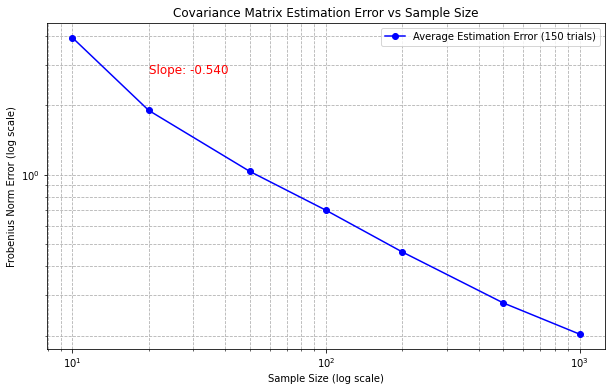

In [109]:
# Parameters
n = 5  # Size of the matrix
num_trials = 150  # Number of trials for averaging
sample_sizes = [10, 20, 50, 100, 200, 500, 1000]
errors_avg = []

# Generate true Theta with a tridiagonal sparsity pattern (1, -2, 1)
true_theta = np.eye(n) * -2
for i in range(n - 1):
    true_theta[i, i + 1] = 1
    true_theta[i + 1, i] = 1

# Ensure positive definiteness
min_eig = np.min(np.linalg.eigvalsh(true_theta))
if min_eig <= 0:
    true_theta += (np.eye(n) * (0.1 - min_eig))

# Define sparsity pattern based on true_theta's non-zero entries
sparsity_pattern = [[j for j in range(n) if true_theta[i, j] != 0] for i in range(n)]

# Function to estimate precision matrix
def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    quadratic_term = 0.5 * cp.trace(Theta @ YTY)
    log_det_term = (m / 2) * cp.log_det(Theta)
    objective = cp.Minimize(quadratic_term - log_det_term)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    return Theta.value

# Main experiment loop with averaging over multiple trials
for m in sample_sizes:
    errors = []
    for _ in range(num_trials):
        Sigma = np.linalg.inv(true_theta)  # Compute covariance matrix
        Y = np.random.multivariate_normal(mean=np.zeros(n), cov=Sigma, size=m)
        YTY = Y.T @ Y  # Compute sufficient statistic
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        error = np.linalg.norm(Theta_est - true_theta, 'fro')  # Frobenius norm
        errors.append(error)
    
    # Compute average error over trials
    errors_avg.append(np.mean(errors))

# Convert to log-log scale
log_sample_sizes = np.log(sample_sizes)
log_errors_avg = np.log(errors_avg)

# Use last few data points to compute slope (asmptotically)
slope, intercept = np.polyfit(log_sample_sizes[3:], log_errors_avg[3:], 1)

# Plot results with logarithmic scales
plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, errors_avg, 'bo-', label='Average Estimation Error (150 trials)')
plt.xlabel('Sample Size (log scale)')
plt.ylabel('Frobenius Norm Error (log scale)')
plt.title('Covariance Matrix Estimation Error vs Sample Size')
plt.grid(True, which='both', linestyle='--')
plt.legend()

# Display slope on the plot
plt.text(20, max(errors_avg) * 0.7, f'Slope: {slope:.3f}', fontsize=12, color='red')

In [110]:
pd.DataFrame(Theta_est)

,0,1,2,3,4
0,1.848112e+00,9.889583e-01,-2.598711e-11,1.899945e-11,-2.096326e-11
1,9.889583e-01,1.828609e+00,1.038215e+00,-1.591242e-11,4.915243e-12
2,-2.598711e-11,1.038215e+00,1.818044e+00,9.572300e-01,2.028961e-11
3,1.899945e-11,-1.591242e-11,9.572300e-01,1.874852e+00,1.047441e+00
4,-2.096326e-11,4.915243e-12,2.028961e-11,1.047441e+00,1.864367e+00


## 1.1 Sample size vs sparsity (Fisher's theorem study)

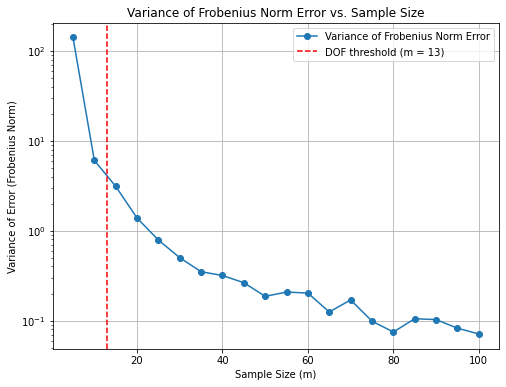

In [84]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- Setup the true precision matrix Theta ---
n = 5  # Size of the matrix

# Create a tridiagonal precision matrix with pattern (1, -2, 1)
true_theta = np.eye(n) * -2
for i in range(n - 1):
    true_theta[i, i + 1] = 1
    true_theta[i + 1, i] = 1

# Ensure positive definiteness by shifting if needed
min_eig = np.min(np.linalg.eigvalsh(true_theta))
if min_eig <= 0:
    true_theta += np.eye(n) * (0.1 - min_eig)

# Compute the true covariance matrix (for data generation)
true_cov = np.linalg.inv(true_theta)

# Define the sparsity pattern: list of column indices where each row has nonzero entries.
sparsity_pattern = [[j for j in range(n) if abs(true_theta[i, j]) > 1e-8] for i in range(n)]

# --- Function to estimate Theta using CVXPY ---
def estimate_theta(YTY, sparsity_pattern, n, m):
    Theta = cp.Variable((n, n), PSD=True)
    # Enforce sparsity: force entries not in the pattern to zero.
    constraints = [Theta[i, j] == 0 for i in range(n) for j in range(n) if j not in sparsity_pattern[i]]
    quadratic_term = 0.5 * cp.trace(Theta @ YTY)
    log_det_term = (m / 2) * cp.log_det(Theta)
    objective = cp.Minimize(quadratic_term - log_det_term)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)
    return Theta.value

# --- Simulation: Compute variance of Frobenius norm error over multiple trials ---
num_trials = 150  # Number of trials per sample size
sample_sizes = range(5, 105, 5)  # Vary sample size m from 0, 5, ..., 100
error_variances = {}  # To store variance of Frobenius norm errors for each m

for m in sample_sizes:
    errors = []
    for trial in range(num_trials):
        # Generate m samples from N(0, true_cov)
        Y = np.random.multivariate_normal(np.zeros(n), true_cov, size=m)
        YTY = Y.T @ Y  # Scatter (covariance) matrix based on the samples
        Theta_est = estimate_theta(YTY, sparsity_pattern, n, m)
        if Theta_est is not None:
            # Compute the Frobenius norm error between the estimated and true precision matrices.
            error = np.linalg.norm(Theta_est - true_theta, 'fro')
            errors.append(error)
    # Store the variance of the errors for this sample size.
    error_variances[m] = np.var(errors)

# --- Plot the Variance vs. Sample Size (using a semilogy plot) ---
plt.figure(figsize=(8, 6))
plt.semilogy(list(error_variances.keys()),
             list(error_variances.values()),
             marker='o',
             label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("Variance of Frobenius Norm Error vs. Sample Size")

# Determine the "degrees of freedom" threshold.
# Total number of nonzero entries in the precision matrix.
dof_threshold = sum(len(p) for p in sparsity_pattern)  # For the 5x5 tridiagonal, this equals 13
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')


plt.legend()
plt.grid(True)
plt.show()


In [85]:
print('Variance:',pd.DataFrame(list(error_variances.values())))

Variance:              0
0   141.481218
1     6.066361
2     3.118871
3     1.383193
4     0.787508
5     0.500899
6     0.349883
7     0.317658
8     0.263949
9     0.186159
10    0.207890
11    0.202439
12    0.124666
13    0.169860
14    0.098580
15    0.074637
16    0.104939
17    0.102615
18    0.082337
19    0.070989


## This plot shows degree of freedom (DOF) impact more clearly

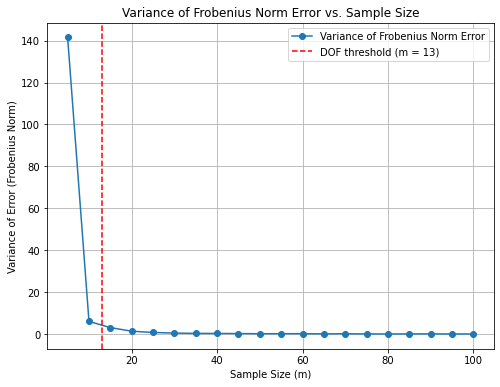

In [114]:
plt.figure(figsize=(8, 6))
plt.plot(list(error_variances.keys()),
           list(error_variances.values()),
           marker='o',
           label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("Variance of Frobenius Norm Error vs. Sample Size")
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')

plt.legend()
plt.grid(True)
plt.show()

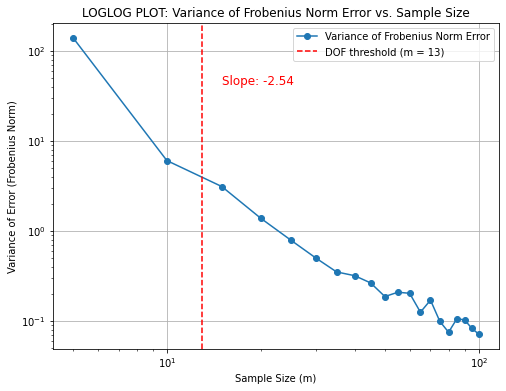

In [106]:
# --- Compute the slope using the last few data points ---
num_points_for_slope = 20  # Use last 5 points for estimation
x_vals = np.array(list(error_variances.keys())[-num_points_for_slope:])
y_vals = np.array(list(error_variances.values())[-num_points_for_slope:])

# Compute slope using log differences
log_x = np.log(x_vals)
log_y = np.log(y_vals)
slope = (log_y[-1] - log_y[0]) / (log_x[-1] - log_x[0])

# --- Plot the Variance vs. Sample Size (using a log-log plot) ---
plt.figure(figsize=(8, 6))
plt.loglog(list(error_variances.keys()),
           list(error_variances.values()),
           marker='o',
           label='Variance of Frobenius Norm Error')

plt.xlabel("Sample Size (m)")
plt.ylabel("Variance of Error (Frobenius Norm)")
plt.title("LOGLOG PLOT: Variance of Frobenius Norm Error vs. Sample Size")

# Add vertical dashed line at the degrees-of-freedom threshold.
plt.axvline(x=dof_threshold, color='red', linestyle='--',
            label=f'DOF threshold (m = {dof_threshold})')

# Display computed slope on the plot
plt.text(15, max(error_variances.values()) * 0.3, f"Slope: {slope:.2f}",
         fontsize=12, color='red')

plt.legend()
plt.grid(True)
plt.show()

## Remark : I don't know why the slope is -3 much better than -1, ($\frac{1}{m}$) that I expect. 

# 2. Closed form solution of Cholesky factor for estimating covariance

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import time

def boundary_dist_func(point):
    return np.linalg.norm(point)

def reverse_maximin_ordering(points):  
    """
    Order points from furthest to closest from the origin.
    Returns a permutation (list of indices).
    """
    n = points.shape[0]
    ordering = []
    remaining = set(range(n))
    while remaining:
        max_dist = -1
        next_point = -1
        for i in remaining:
            dist = boundary_dist_func(points[i])
            if dist > max_dist:
                max_dist = dist
                next_point = i
        ordering.append(next_point)
        remaining.remove(next_point)
    return ordering

def compute_sparsity_pattern_perm(points, rho):
    """
    Given points in the permuted (elimination) order, compute a sparsity pattern.
    For each point i, we include all indices j (with j>=i) for which
      distance(points[i], points[j]) <= rho * boundary_dist_func(points[i]).
    """
    n = points.shape[0]
    tree = KDTree(points)
    sparsity = [[] for _ in range(n)]
    for i in range(n):
        radius = rho * boundary_dist_func(points[i])
        neighbors = tree.query_ball_point(points[i], radius)
        # Only keep neighbors that come later in the ordering
        sparsity[i] = [j for j in neighbors if j >= i]
    return sparsity

def kl_minimization_column(Theta_sk_sk):
    """
    Given the submatrix Theta_sk_sk corresponding to an index set sk,
    compute the vector L_sk solving a certain minimization problem.
    (This is a closed-form formula from the paper.)
    """
    reg = 1e-3 * np.eye(len(Theta_sk_sk))  # regularization term
    print('Shape of sub_matrix used for inversion:',np.shape(Theta_sk_sk))
    inv = np.linalg.inv(Theta_sk_sk + reg)
    e1 = np.zeros(len(inv))
    e1[0] = 1
    L_sk = inv @ e1
    L_sk /= np.sqrt(e1 @ inv @ e1)
    return L_sk

# ============================
# Generate synthetic data
# ============================
np.random.seed(0)
n = 500
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Create full covariance matrix using the Gaussian kernel
Theta_true = np.array([[gaussian_kernel(points[i], points[j])
                        for j in range(n)] for i in range(n)])

# ============================
# Small-scale test case
# ============================
matsize = 10   # Test matrix size
subset = np.array(list(range(matsize)))  # indices of the subset
# Regularize the small covariance submatrix
Theta_sub = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)

# ----------------------------
# Reorder the data according to reverse maximin ordering.
# ----------------------------
ordering = reverse_maximin_ordering(points[subset])
# Permute the points and Theta_sub into the elimination order
points_perm = points[subset][ordering]
Theta_sub_perm = Theta_sub[np.ix_(ordering, ordering)]

# ----------------------------
# Compute the sparsity pattern in the permuted ordering.
# ----------------------------
rho = 2
sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho)

# ----------------------------
# Compute the approximate factor L in the permuted ordering.
# ----------------------------
L_perm = np.zeros((matsize, matsize))
for i in range(matsize):
    # Use the sparsity pattern for the i-th column.
    sk = sparsity_perm[i]
    # Ensure that the diagonal (i) is included and appears first.
    if i not in sk:
        sk = [i]
    else:
        # Force diagonal first if not already
        sk = [i] + [j for j in sk if j != i]
    Theta_sk_sk = Theta_sub_perm[np.ix_(sk, sk)]
    L_sk = kl_minimization_column(Theta_sk_sk)
    L_perm[sk, i] = L_sk

# ----------------------------
# Reconstruct the approximate covariance matrix in the permuted ordering.
# ----------------------------
Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)

# ----------------------------
# Undo the permutation to get the estimate back in the original ordering.
# ----------------------------
# Compute the inverse permutation
ip = np.argsort(ordering)
Theta_est = Theta_est_perm[np.ix_(ip, ip)]

# ----------------------------
# Compute the error (Frobenius norm)
# ----------------------------
error = np.linalg.norm(Theta_est - Theta_sub, 'fro')
print("Error:", error)


Shape of sub_matrix used for inversion: (10, 10)
Shape of sub_matrix used for inversion: (9, 9)
Shape of sub_matrix used for inversion: (8, 8)
Shape of sub_matrix used for inversion: (7, 7)
Shape of sub_matrix used for inversion: (6, 6)
Shape of sub_matrix used for inversion: (5, 5)
Shape of sub_matrix used for inversion: (4, 4)
Shape of sub_matrix used for inversion: (3, 3)
Shape of sub_matrix used for inversion: (2, 2)
Shape of sub_matrix used for inversion: (1, 1)
Error: 0.0031622776602560124


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import time

def boundary_dist_func(point):
    return np.linalg.norm(point)

def reverse_maximin_ordering(points):  
    """
    Order points from furthest to closest from the origin.
    Returns a permutation (list of indices).
    """
    n = points.shape[0]
    ordering = []
    remaining = set(range(n))
    while remaining:
        max_dist = -1
        next_point = -1
        for i in remaining:
            dist = boundary_dist_func(points[i])
            if dist > max_dist:
                max_dist = dist
                next_point = i
        ordering.append(next_point)
        remaining.remove(next_point)
    return ordering

def compute_sparsity_pattern_perm(points, rho, max_neighbors):
    """
    Given points in the permuted (elimination) order, compute a sparsity pattern.
    For each point i, we include up to max_neighbors indices j (with j >= i)
    that satisfy: distance(points[i], points[j]) <= rho * boundary_dist_func(points[i]).
    We also ensure that the diagonal index (i) is included and placed first.
    """
    n = points.shape[0]
    tree = KDTree(points)
    sparsity = [[] for _ in range(n)]
    for i in range(n):
        radius = rho * boundary_dist_func(points[i])
        # Find all indices within the given radius.
        neighbors = tree.query_ball_point(points[i], radius)
        # Only consider indices that come at or after i.
        neighbors = [j for j in neighbors if j >= i]
        # Sort neighbors by distance from points[i]
        neighbors = sorted(neighbors, key=lambda j: np.linalg.norm(points[j]-points[i]))
        # Ensure the diagonal is first.
        if i not in neighbors:
            neighbors = [i] + neighbors
        else:
            neighbors.remove(i)
            neighbors = [i] + neighbors
        # Restrict to at most max_neighbors entries.
        sparsity[i] = neighbors[:max_neighbors]
    return sparsity

def kl_minimization_column(Theta_sk_sk):
    """
    Given the submatrix Theta_sk_sk corresponding to an index set sk,
    compute the vector L_sk solving a closed-form minimization problem.
    A regularization term is added for numerical stability.
    """
    reg = 1e-3 * np.eye(len(Theta_sk_sk))
    print('Shape of sub_matrix used for inversion:', np.shape(Theta_sk_sk))
    inv = np.linalg.inv(Theta_sk_sk + reg)
    e1 = np.zeros(len(inv))
    e1[0] = 1
    L_sk = inv @ e1
    L_sk /= np.sqrt(e1 @ inv @ e1)
    return L_sk

# ============================
# Generate synthetic data
# ============================
np.random.seed(0)
n = 500      # total number of points for the full covariance
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Create full covariance matrix using the Gaussian kernel.
Theta_true = np.array([[gaussian_kernel(points[i], points[j])
                        for j in range(n)] for i in range(n)])

# ============================
# Small-scale test case
# ============================
matsize = 100                     # Test matrix size
subset = np.array(list(range(matsize)))  # indices of the subset
# Regularize the small covariance submatrix.
Theta_sub = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)

# ----------------------------
# Reorder the data according to reverse maximin ordering.
# ----------------------------
ordering = reverse_maximin_ordering(points[subset])
# Permute the points and Theta_sub into the elimination order.
points_perm = points[subset][ordering]
Theta_sub_perm = Theta_sub[np.ix_(ordering, ordering)]

# ----------------------------
# Compute the sparsity pattern in the permuted ordering.
# ----------------------------
rho = 2
max_neighbors = 100   # Limit the number of neighbors per column.
sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)

# ----------------------------
# Compute the approximate factor L in the permuted ordering.
# ----------------------------
L_perm = np.zeros((matsize, matsize))
for i in range(matsize):
    # Use the sparsity pattern for the i-th column.
    sk = sparsity_perm[i]
    # Now sk has at most max_neighbors indices.
    Theta_sk_sk = Theta_sub_perm[np.ix_(sk, sk)]
    L_sk = kl_minimization_column(Theta_sk_sk)
    L_perm[sk, i] = L_sk

# ----------------------------
# Reconstruct the approximate covariance matrix in the permuted ordering.
# ----------------------------
Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)

# ----------------------------
# Undo the permutation to get the estimate back in the original ordering.
# ----------------------------
ip = np.argsort(ordering)
Theta_est = Theta_est_perm[np.ix_(ip, ip)]

# ----------------------------
# Compute the error (Frobenius norm)
# ----------------------------
error = np.linalg.norm(Theta_est - Theta_sub, 'fro')
print("Error:", error)


Shape of sub_matrix used for inversion: (100, 100)
Shape of sub_matrix used for inversion: (99, 99)
Shape of sub_matrix used for inversion: (98, 98)
Shape of sub_matrix used for inversion: (97, 97)
Shape of sub_matrix used for inversion: (96, 96)
Shape of sub_matrix used for inversion: (95, 95)
Shape of sub_matrix used for inversion: (94, 94)
Shape of sub_matrix used for inversion: (93, 93)
Shape of sub_matrix used for inversion: (92, 92)
Shape of sub_matrix used for inversion: (91, 91)
Shape of sub_matrix used for inversion: (90, 90)
Shape of sub_matrix used for inversion: (89, 89)
Shape of sub_matrix used for inversion: (88, 88)
Shape of sub_matrix used for inversion: (87, 87)
Shape of sub_matrix used for inversion: (86, 86)
Shape of sub_matrix used for inversion: (85, 85)
Shape of sub_matrix used for inversion: (84, 84)
Shape of sub_matrix used for inversion: (83, 83)
Shape of sub_matrix used for inversion: (82, 82)
Shape of sub_matrix used for inversion: (81, 81)
Shape of sub_matri

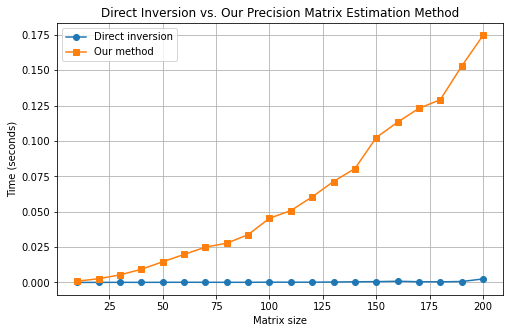

In [80]:
def kl_minimization_column(Theta_sk_sk):
    """
    Given the submatrix Theta_sk_sk corresponding to an index set sk,
    compute the vector L_sk solving a closed-form minimization problem.
    A regularization term is added for numerical stability.
    """
    reg = 1e-3 * np.eye(len(Theta_sk_sk))
    inv = np.linalg.inv(Theta_sk_sk + reg)
    e1 = np.zeros(len(inv))
    e1[0] = 1
    L_sk = inv @ e1
    L_sk /= np.sqrt(e1 @ inv @ e1)
    return L_sk

# -------------------------------------------------
# Data Generation
# -------------------------------------------------

np.random.seed(0)
n = 500      # Total number of points; we will use subsets of these.
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Precompute the full covariance matrix using the Gaussian kernel.
# (We will extract submatrices of various sizes from this.)
Theta_true = np.array([[gaussian_kernel(points[i], points[j])
                        for j in range(n)] for i in range(n)])

# -------------------------------------------------
# Timing Comparison over Varying Matrix Sizes
# -------------------------------------------------

# Parameters for timing
num_trials = 10       # average time over these many trials
sizes = list(range(10, 201, 10))   # Vary submatrix size from 10 up to 200
rho = 2               # Parameter for computing the sparsity pattern

direct_times = []
method_times = []

for matsize in sizes:
    direct_time_total = 0.0
    method_time_total = 0.0
    
    for trial in range(num_trials):
        # Select a subset of the points and corresponding covariance matrix.
        subset = np.arange(matsize)
        Theta_sub = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)
        
        # -------- Direct Inversion Timing --------
        start = time.perf_counter()
        Theta_inv_direct = np.linalg.inv(Theta_sub)
        direct_time_total += time.perf_counter() - start
        
        # -------- Our Sparse Method Timing --------
        start = time.perf_counter()
        
        # 1. Reorder points according to reverse maximin ordering.
        ordering = reverse_maximin_ordering(points[subset])
        points_perm = points[subset][ordering]
        Theta_sub_perm = Theta_sub[np.ix_(ordering, ordering)]
        
        # 2. Compute sparsity pattern in the permuted ordering.
        sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)
        
        # 3. Compute the approximate factor L in the permuted ordering.
        L_perm = np.zeros((matsize, matsize))
        for i in range(matsize):
            # Use the sparsity pattern for the i-th column.
            sk = sparsity_perm[i]
            # Ensure that the diagonal (i) is included and appears first.
            if i not in sk:
                sk = [i]
            else:
                sk = [i] + [j for j in sk if j != i]
            Theta_sk_sk = Theta_sub_perm[np.ix_(sk, sk)]
            L_sk = kl_minimization_column(Theta_sk_sk)
            L_perm[sk, i] = L_sk
        
#         # 4. Reconstruct the approximate covariance and then compute its pseudo-inverse.
#         Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)
        
#         # 5. Undo the permutation to return to the original ordering.
#         ip = np.argsort(ordering)
#         Theta_est = Theta_est_perm[np.ix_(ip, ip)]
        
        method_time_total += time.perf_counter() - start

    direct_times.append(direct_time_total / num_trials)
    method_times.append(method_time_total / num_trials)

# -------------------------------------------------
# Plot the Results
# -------------------------------------------------

plt.figure(figsize=(8, 5))
plt.plot(sizes, direct_times, 'o-', label="Direct inversion")
plt.plot(sizes, method_times, 's-', label="Our method")
plt.xlabel("Matrix size")
plt.ylabel("Time (seconds)")
plt.title("Direct Inversion vs. Our Precision Matrix Estimation Method")
plt.legend()
plt.grid(True)
plt.show()


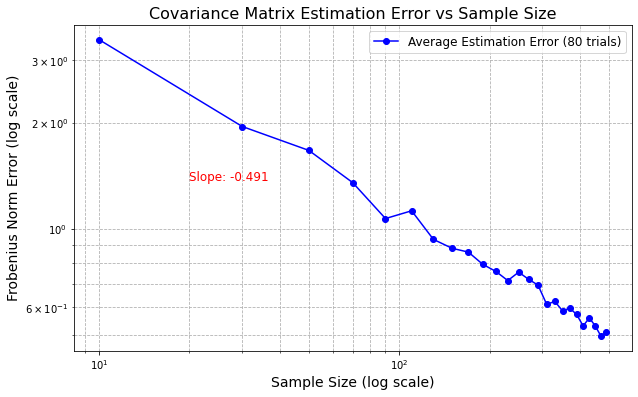

In [81]:
# ------------------------------
# Data Generation
# ------------------------------
np.random.seed(0)
n = 500  # total number of points for the full covariance
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Create the full 500×500 covariance matrix using the Gaussian kernel.
Theta_true = np.array([[gaussian_kernel(points[i], points[j]) 
                        for j in range(n)] for i in range(n)])

# ------------------------------
# Test Submatrix Setup (matsize = 10)
# ------------------------------
matsize = 10
subset = np.array(list(range(matsize)))
# Define the "true" 10x10 covariance for our test (with a little regularization).
Theta_sub_true = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)

# ------------------------------
# Experiment: Vary the Number of Samples
# ------------------------------
sample_sizes = np.arange(10, 501, 20)  # sample sizes from 10 to 500
num_trials = 80                       # average over 80 trials for each sample size
errors_avg = []                       # will store average error for each sample size
rho = 2                               # parameter for the sparsity pattern
max_neighbors = 100                  # Limit the number of neighbors per column.

for N in sample_sizes:
    trial_errors = []
    for trial in range(num_trials):
        # Generate N samples from N(0, Theta_sub_true)
        samples = np.random.multivariate_normal(mean=np.zeros(matsize), 
                                                cov=Theta_sub_true, 
                                                size=N)
        # Compute the sample covariance (biased estimator with 1/N normalization)
        Theta_sample = np.cov(samples, rowvar=False, bias=True)   #Each row is an independet observation
        
        # --- Apply your method to estimate the covariance ---
        # 1. Compute reverse maximin ordering (using the fixed subset points).
        ordering = reverse_maximin_ordering(points[subset])
        # 2. Permute the points and sample covariance into elimination order.
        points_perm = points[subset][ordering]
        Theta_sample_perm = Theta_sample[np.ix_(ordering, ordering)]
        # 3. Compute the sparsity pattern in the permuted ordering.
        sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)
        # 4. Compute the approximate factor L (column-by-column).
        L_perm = np.zeros((matsize, matsize))      
        for i in range(matsize):
            sk = sparsity_perm[i]
            # Ensure the diagonal element is included and placed first.
            if i not in sk:
                sk = [i]
            else:
                sk = [i] + [j for j in sk if j != i]
            Theta_sk_sk = Theta_sample_perm[np.ix_(sk, sk)]
            L_sk = kl_minimization_column(Theta_sk_sk)
            L_perm[sk, i] = L_sk
        # 5. Reconstruct the estimated covariance from the factor L.
        Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)
        # 6. Undo the permutation to return to the original ordering.
        ip = np.argsort(ordering)
        Theta_est = Theta_est_perm[np.ix_(ip, ip)]
        
        # Compute the Frobenius norm error between estimated and true covariance.
        error = np.linalg.norm(Theta_est - Theta_sub_true, 'fro')
        
#         error = np.linalg.norm(Theta_sample - Theta_sub_true, 'fro') #Test without Cholesky
        
        trial_errors.append(error)
    errors_avg.append(np.mean(trial_errors))

# ------------------------------
# Log-Log Analysis and Plotting
# ------------------------------
# Convert to log–log scale.
log_sample_sizes = np.log(sample_sizes)
log_errors_avg = np.log(errors_avg)

# Compute the slope via linear regression in log–log space.
slope, intercept = np.polyfit(log_sample_sizes, log_errors_avg, 1)

# Plot the results on logarithmic scales.
plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, errors_avg, 'bo-', label='Average Estimation Error (80 trials)')
plt.xlabel('Sample Size (log scale)', fontsize=14)
plt.ylabel('Frobenius Norm Error (log scale)', fontsize=14)
plt.title('Covariance Matrix Estimation Error vs Sample Size', fontsize=16)
plt.grid(True, which='both', linestyle='--')
plt.legend(fontsize=12)

# Display the slope on the plot.
plt.text(20, max(errors_avg) * 0.4, f'Slope: {slope:.3f}', fontsize=12, color='red')
plt.show()


## - Plot shows Monte Carlo sqrt(n) rate

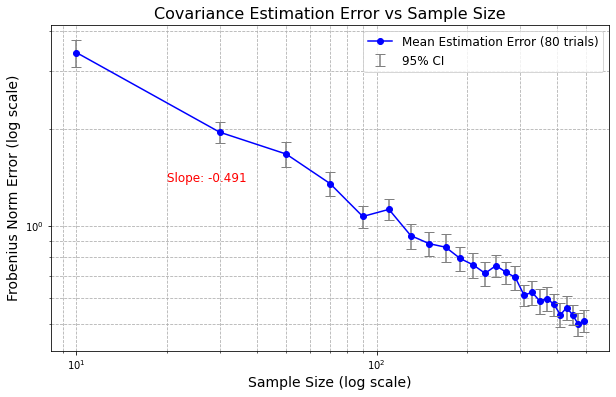

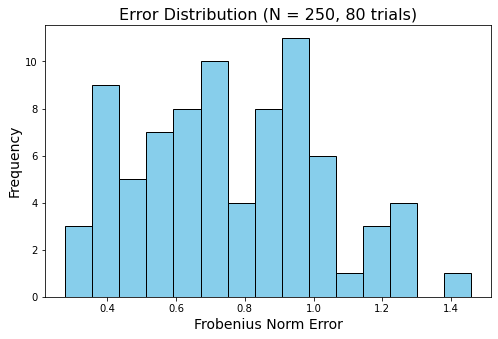

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# ------------------------------
# Helper Functions
# ------------------------------
def boundary_dist_func(point):
    return np.linalg.norm(point)

def reverse_maximin_ordering(points):  
    """
    Order points from furthest to closest from the origin.
    Returns a permutation (list of indices).
    """
    n = points.shape[0]
    ordering = []
    remaining = set(range(n))
    while remaining:
        max_dist = -1
        next_point = -1
        for i in remaining:
            dist = boundary_dist_func(points[i])
            if dist > max_dist:
                max_dist = dist
                next_point = i
        ordering.append(next_point)
        remaining.remove(next_point)
    return ordering

def compute_sparsity_pattern_perm(points, rho, max_neighbors):
    """
    For points in the permuted (elimination) order, compute a sparsity pattern.
    For each point i, we find all indices j (with j >= i) that satisfy:
         distance(points[i], points[j]) <= rho * boundary_dist(points[i]),
    then we sort them by distance and keep at most max_neighbors entries.
    We ensure that the diagonal index (i) is included and placed first.
    """
    n = points.shape[0]
    tree = KDTree(points)
    sparsity = [[] for _ in range(n)]
    for i in range(n):
        radius = rho * boundary_dist_func(points[i])
        # Find all indices within the given radius.
        neighbors = tree.query_ball_point(points[i], radius)
        # Only keep indices that are >= i.
        neighbors = [j for j in neighbors if j >= i]
        # Sort neighbors by distance from points[i]
        neighbors = sorted(neighbors, key=lambda j: np.linalg.norm(points[j]-points[i]))
        # Ensure that i appears first.
        if i not in neighbors:
            neighbors = [i] + neighbors
        else:
            neighbors.remove(i)
            neighbors = [i] + neighbors
        # Restrict to at most max_neighbors.
        sparsity[i] = neighbors[:max_neighbors]
    return sparsity

def kl_minimization_column(Theta_sk_sk):
    """
    Given the submatrix Theta_sk_sk corresponding to an index set sk,
    compute the vector L_sk solving a closed-form minimization problem.
    A regularization term is added for numerical stability.
    """
    reg = 1e-3 * np.eye(len(Theta_sk_sk))
    # Uncomment the next line to see the size of the submatrix
    # print('Shape of sub_matrix used for inversion:', np.shape(Theta_sk_sk))
    inv = np.linalg.inv(Theta_sk_sk + reg)
    e1 = np.zeros(len(inv))
    e1[0] = 1
    L_sk = inv @ e1
    L_sk /= np.sqrt(e1 @ inv @ e1)
    return L_sk

# ------------------------------
# Data Generation
# ------------------------------
np.random.seed(0)
n = 500  # total number of points for the full covariance
d = 1
points = np.random.randn(n, d)

def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Create the full 500×500 covariance matrix using the Gaussian kernel.
Theta_true = np.array([[gaussian_kernel(points[i], points[j]) 
                        for j in range(n)] for i in range(n)])

# ------------------------------
# Test Submatrix Setup (matsize = 10)
# ------------------------------
matsize = 10
subset = np.array(list(range(matsize)))
# Define the "true" 10x10 covariance for our test (with a little regularization).
Theta_sub_true = Theta_true[np.ix_(subset, subset)] + 1e-3 * np.eye(matsize)

# ------------------------------
# Experiment: Vary the Number of Samples
# ------------------------------
sample_sizes = np.arange(10, 501, 20)  # sample sizes from 10 to 500
num_trials = 80                       # number of trials per sample size
errors_by_sample = {}                 # to store trial errors for each sample size

rho = 2                               # parameter for the sparsity pattern
max_neighbors = 100                   # limit on neighbors (here, in a 10x10 submatrix, it might be all)

for N in sample_sizes:
    trial_errors = []
    for trial in range(num_trials):
        # Generate N samples from N(0, Theta_sub_true)
        samples = np.random.multivariate_normal(mean=np.zeros(matsize), 
                                                cov=Theta_sub_true, 
                                                size=N)
        # Compute the sample covariance (biased estimator with 1/N normalization)
        Theta_sample = np.cov(samples, rowvar=False, bias=True)
        
        # --- Apply the method to estimate the covariance ---
        # 1. Compute reverse maximin ordering (using the fixed subset points).
        ordering = reverse_maximin_ordering(points[subset])
        # 2. Permute the points and sample covariance into elimination order.
        points_perm = points[subset][ordering]
        Theta_sample_perm = Theta_sample[np.ix_(ordering, ordering)]
        # 3. Compute the sparsity pattern in the permuted ordering.
        sparsity_perm = compute_sparsity_pattern_perm(points_perm, rho, max_neighbors)
        # 4. Compute the approximate factor L (column-by-column).
        L_perm = np.zeros((matsize, matsize))
        for i in range(matsize):
            sk = sparsity_perm[i]
            # Ensure the diagonal element is included and placed first.
            if i not in sk:
                sk = [i]
            else:
                sk = [i] + [j for j in sk if j != i]
            Theta_sk_sk = Theta_sample_perm[np.ix_(sk, sk)]
            L_sk = kl_minimization_column(Theta_sk_sk)
            L_perm[sk, i] = L_sk
        # 5. Reconstruct the estimated covariance from the factor L.
        Theta_est_perm = np.linalg.pinv(L_perm @ L_perm.T)
        # 6. Undo the permutation to return to the original ordering.
        ip = np.argsort(ordering)
        Theta_est = Theta_est_perm[np.ix_(ip, ip)]
        
        # Compute the Frobenius norm error between estimated and true covariance.
        error = np.linalg.norm(Theta_est - Theta_sub_true, 'fro')
        trial_errors.append(error)
    errors_by_sample[N] = trial_errors

# Compute mean error and 95% confidence intervals for each sample size.
sample_means = []
lower_bounds = []
upper_bounds = []

for N in sample_sizes:
    errors = np.array(errors_by_sample[N])
    mean_err = np.mean(errors)
    std_err = np.std(errors, ddof=1) / np.sqrt(num_trials)
    # 95% CI using normal approximation (t-value ~1.96 for large num_trials)
    ci_half_width = 1.96 * std_err
    sample_means.append(mean_err)
    lower_bounds.append(mean_err - ci_half_width)
    upper_bounds.append(mean_err + ci_half_width)

# ------------------------------
# Log-Log Analysis and Plotting
# ------------------------------
log_sample_sizes = np.log(sample_sizes)
log_means = np.log(sample_means)
slope, intercept = np.polyfit(log_sample_sizes, log_means, 1)

plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, sample_means, 'bo-', label='Mean Estimation Error (80 trials)')
plt.errorbar(sample_sizes, sample_means, 
             yerr=[np.array(sample_means) - np.array(lower_bounds), 
                   np.array(upper_bounds) - np.array(sample_means)], 
             fmt='none', ecolor='gray', capsize=5, label='95% CI')
plt.xlabel('Sample Size (log scale)', fontsize=14)
plt.ylabel('Frobenius Norm Error (log scale)', fontsize=14)
plt.title('Covariance Estimation Error vs Sample Size', fontsize=16)
plt.grid(True, which='both', linestyle='--')
plt.legend(fontsize=12)
plt.text(20, max(sample_means) * 0.4, f'Slope: {slope:.3f}', fontsize=12, color='red')
plt.show()

# ------------------------------
# Plot the error distribution for one sample size
# ------------------------------
# For example, plot the histogram of errors for sample size = 250.
selected_N = 250
errors_selected = errors_by_sample[selected_N]

plt.figure(figsize=(8, 5))
plt.hist(errors_selected, bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Frobenius Norm Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Error Distribution (N = {selected_N}, 80 trials)', fontsize=16)
plt.show()
